In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utils import load, dump
from evaluate import eval, Evaluator
from os import getcwd
from tqdm import tqdm
import torch

In [4]:
root = f'{getcwd()}/..'
path = lambda p: f'{root}/../out/{p}'

In [5]:
testset = load(f'{root}/data/prd_backtick-se_cowait_annotated.json')

def evaluate(predict):    
    y_true = []
    y_pred = []

    for pr in tqdm(testset):
        title = pr['title']
        pcat = predict(title)
        tcat = pr['category']

        y_true.append(tcat)
        y_pred.append(pcat)
    
    eval(y_true, y_pred)

def progress(model):
    ev = Evaluator(path(model))
    ev.plot_progress()
    evaluate(ev.predict)

def compare(*models):
    model_files = [*map(path, models)]
    evaluators = [*map(Evaluator, model_files)]
    Evaluator.compare(*evaluators)

## Let's evaluate the transformer classifiers

### Frozen base results for each checkpoint
DistilBERT and CodeBERTa showing best base config results

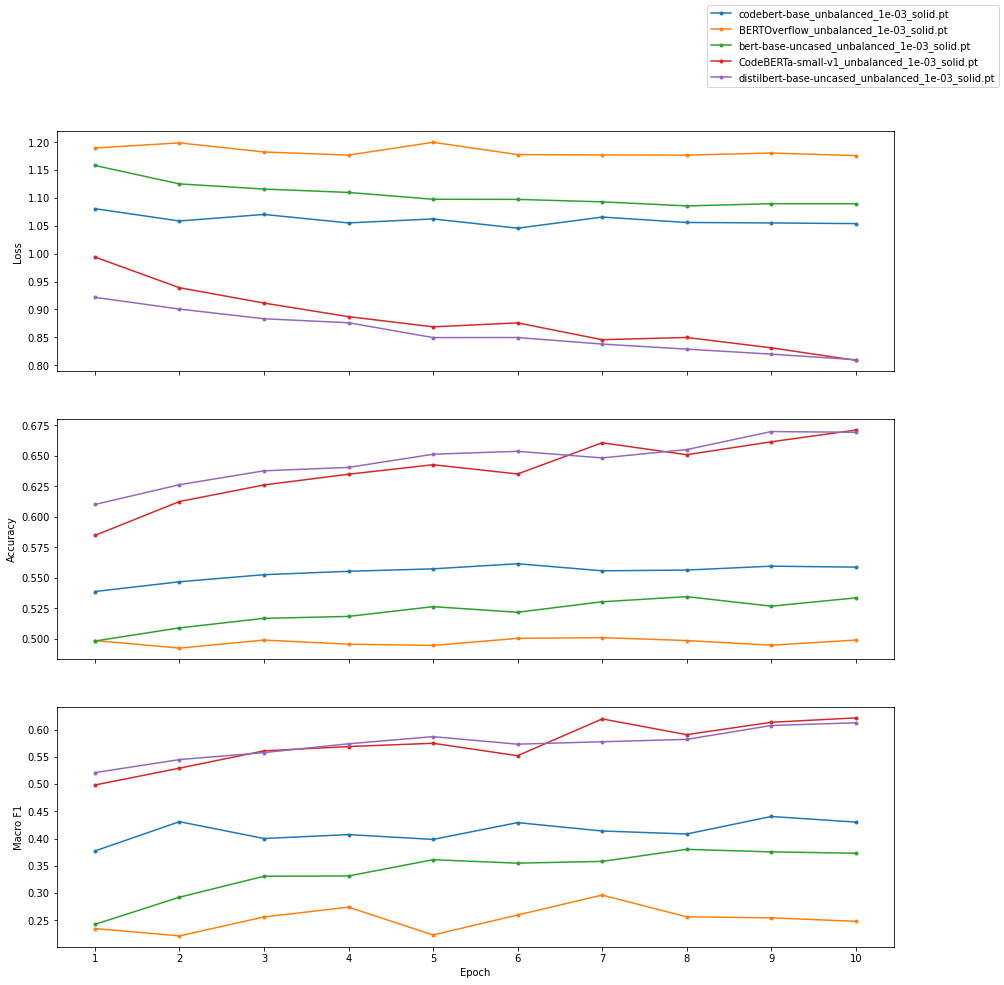

In [6]:
compare(
    'codebert-base_unbalanced_1e-03_solid.pt',
    'BERTOverflow_unbalanced_1e-03_solid.pt',
    'bert-base-uncased_unbalanced_1e-03_solid.pt',
    'CodeBERTa-small-v1_unbalanced_1e-03_solid.pt',
    'distilbert-base-uncased_unbalanced_1e-03_solid.pt',
)

### Thaw impact CodeBERTa
Model reaction to unfreezing a couple of base layers.

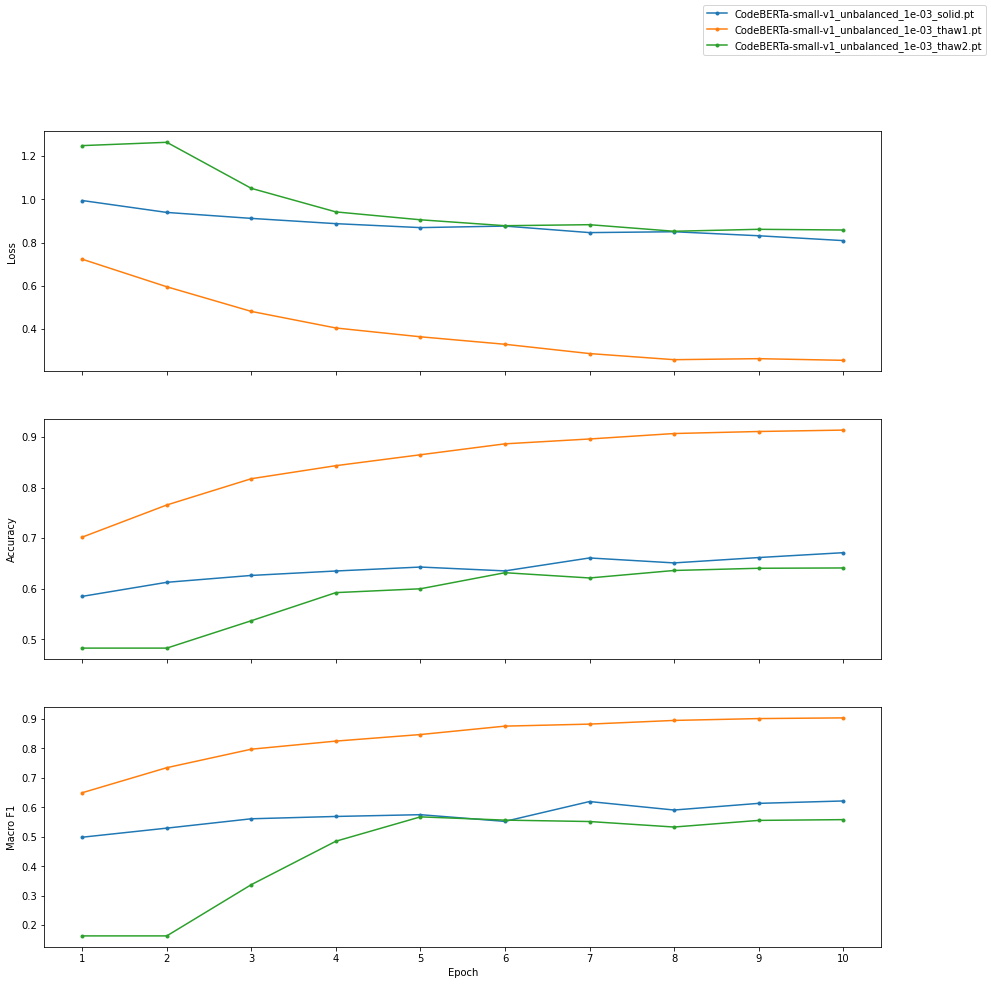

In [7]:
compare(
    'CodeBERTa-small-v1_unbalanced_1e-03_solid.pt',
    'CodeBERTa-small-v1_unbalanced_1e-03_thaw1.pt',
    'CodeBERTa-small-v1_unbalanced_1e-03_thaw2.pt',
    #'CodeBERTa-small-v1_unbalanced_1e-03_thaw3.pt',
)

### Thaw impact DistilBERT
Model reaction to unfreezing a couple of base layers.

In [ ]:
compare(
    'distilbert-base-uncased_unbalanced_1e-03_solid.pt',
    'distilbert-base-uncased_unbalanced_1e-03_thaw1.pt',
    'distilbert-base-uncased_unbalanced_1e-03_thaw2.pt',
    #'distilbert-base-uncased_unbalanced_1e-03_thaw3.pt',
)

### Best of both bases